In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from tqdm import trange
import pandas as pd
pd.set_option('expand_frame_repr', False)
from matplotlib.ticker import FormatStrFormatter  
sns.set(font_scale=2)
import sys
import json
import os
import re
from scipy.stats import pearsonr
import pickle

## Util

In [2]:
dataset_name = ['ETTm1','ETTm2','ETTh1','ETTh2','Exchange','Weather', 'Traffic', 'Electricity','ILI', 'Solar Hour', 'Solar 10min', 'River Flow', 'Sunspot']
datasets = ['ettm1','ettm2','etth1','etth2','exchange_ltsf','weather_ltsf','illness_ltsf','sunspot', 'solar_hour', 'solar_10min','river_flow']
def replace_dataset_name(df):
    df['dataset'] = df['dataset'].replace('ettm1', 'ETTm1', regex=True) 
    df['dataset'] = df['dataset'].replace('ettm2', 'ETTm2', regex=True) 
    df['dataset'] = df['dataset'].replace('etth1', 'ETTh1', regex=True) 
    df['dataset'] = df['dataset'].replace('etth2', 'ETTh2', regex=True) 
    df['dataset'] = df['dataset'].replace('exchange_ltsf', 'Exchange', regex=True) 
    df['dataset'] = df['dataset'].replace('weather_ltsf', 'Weather', regex=True) 
    df['dataset'] = df['dataset'].replace('traffic_ltsf', 'Traffic', regex=True) 
    df['dataset'] = df['dataset'].replace('electricity_ltsf', 'Electricity', regex=True) 
    df['dataset'] = df['dataset'].replace('illness_ltsf', 'ILI', regex=True) 
    df['dataset'] = df['dataset'].replace('solar_hour', 'Solar Hour', regex=True) 
    df['dataset'] = df['dataset'].replace('solar_10min', 'Solar 10min', regex=True) 
    df['dataset'] = df['dataset'].replace('river_flow', 'River Flow', regex=True) 
    df['dataset'] = df['dataset'].replace('sunspot', 'Sunspot', regex=True) 
    return df

def sort_order(cat_res, sort_order_dict=None, inf_sort_order=False):
    # cat_res = cat_res.loc[cat_res['Infer hor.'] != '24']
    
    # inf_sort_order = ['48', '60', '96', '192', '336', '720', '1024']
    if inf_sort_order:
        inf_sort_order = ['24', '48', '96', '192','336', '720', '1024']
        cat_res['Infer hor.'] = pd.Categorical(cat_res['Infer hor.'], categories=inf_sort_order, ordered=True)
        cat_res = cat_res.sort_values(by='Infer hor.')
    
    if sort_order_dict is not None:
        for key, value in sort_order_dict.items():
            cat_res[key] = pd.Categorical(cat_res[key], categories=value, ordered=True)
            cat_res = cat_res.sort_values(by=key)
    
    return cat_res

def filed_filter(df, fileds_dict, eq=True):
    for key, values in fileds_dict.items():
        if eq:
            df = df[df[key].isin(values)]
        else:
            df = df[~df[key].isin(values)]
                
    return df

def add_spec_setting(res_dict, prefix=''):
    datasets = []
    infer_hor = []
    train_hor = []
    val_hor = []
    ND = []
    NRMSE = []
    seed = []
    for dataset in ['ETTm1','ETTm2','ETTh1','ETTh2','Exchange','Weather', 'Electricity','Traffic', 'Solar Hour', 'Solar 10min', 'River Flow', 'Sunspot']:
        for hor in ['96', '192', '336', '720']:
            try: 
                ND.append(res_dict[(res_dict['val_len']==hor) & (res_dict['Infer hor.']==hor) & (res_dict['Train hor.']==hor) & (res_dict['dataset']==dataset)]['ND'].values[0])
                NRMSE.append(res_dict[(res_dict['val_len']==hor) & (res_dict['Infer hor.']==hor) & (res_dict['Train hor.']==hor) & (res_dict['dataset']==dataset)]['NRMSE'].values[0])
                datasets.append(dataset)
                infer_hor.append(hor)
                train_hor.append(prefix+'spec')
                val_hor.append(prefix+'spec')
                seed.append(0)
            except:
                continue
            
    res_dict = {"dataset": datasets, "Infer hor.": infer_hor, "Train hor.": train_hor, "val_len": val_hor, "ND": ND , "NRMSE": NRMSE, "seeds": seed,}
    return pd.DataFrame(res_dict)

def plot_multi_marked_line(res,  x,  y, hue=None, style=None, title=None, datasets=['ETTh1'],save_name=None,line_styles=False, 
                           line_style_list=None,errorbar=None, palette=None, data_char=None, axvline=None,axhline=None, axhline_label=None,
                           hight=5, width=6, x_min=None, x_max=None, all_in_one=False, font_scale=1.5):
    sns.set(font_scale=font_scale)
    sub_num = len(datasets)
    if palette:
        sns.set_palette(palette)
    if sub_num > 1 and not all_in_one:
        plt.figure()
        total_len = sub_num * width
        fig, ax = plt.subplots(1, sub_num,figsize=(total_len, hight))  
        legend = False
        for i in range(sub_num):
            if line_style_list is not None:
                local_line_style = line_style_list[i]
            else:
                local_line_style = line_styles
                
            if datasets[i] == 'ETT':
                sub_res = res[(res['dataset']=='ETTm1') | (res['dataset']=='ETTm2') | (res['dataset']=='ETTh1') | (res['dataset']=='ETTh2')]
            else:
                sub_res = res[res['dataset']==datasets[i]]
                
            if i == (sub_num-1):
                legend = True
            sns.lineplot(
                data=sub_res, legend=legend,
                x=x, y=y, hue=hue, style=style, ax=ax[i], errorbar=errorbar,
                markers=True, dashes=local_line_style, linewidth=2,markersize=10
            )
            if axvline is not None:
                ax[i].axvline(x=axvline, color='r', linestyle='--', linewidth=2,markersize=10) 
            ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            
            if data_char is not None:
                season = data_char[datasets[i]]['Seasonality']
                trend = data_char[datasets[i]]['Trend']
                data_char_str = f'\nFs:{season} Ft:{trend}'
            else:
                data_char_str = ''
            ax[i].set_title(f'{datasets[i]}{data_char_str}')  
            ax[i].tick_params(axis='y', labelsize=15)    
            ax[i].tick_params(axis='x', labelsize=16)    
            if i > 0:
                ax[i].set_ylabel('')
                
        if title is not None:
            fig.suptitle(title)
    else:
        plt.figure(figsize=(width, hight))
        if datasets[0] == 'ETT':
            sub_res = res[(res['dataset']=='ETTm1') | (res['dataset']=='ETTm2') | (res['dataset']=='ETTh1') | (res['dataset']=='ETTh2')]
        else:
            # sub_res = res[res['dataset']==datasets[0]]
            sub_res = res[res['dataset'].isin(datasets)]
        sns.lineplot(
            data=sub_res,
            x=x, 
            y=y, 
            hue=hue, style=style, errorbar=None,
            markers=True, dashes=line_styles, linewidth=2, markersize=10
        )
        if axvline is not None:
            plt.axvline(x=axvline, color='r', linestyle='--', linewidth=2,markersize=10) 
            
        if axhline is not None:
            plt.axhline(y=axhline, color='gray', linestyle='--', linewidth=2, label=axhline_label)
        
        if x_min is not None:
            plt.xlim(x_min, x_max)
            
        if title is not None:
            plt.title(title)
    
    # plt.legend(title=hue, loc='upper left', bbox_to_anchor=(1, 1))  
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1),title=hue)  
    plt.tight_layout() 
    if save_name is not None:
        plt.savefig(f'fig/{save_name}.svg', format='svg') 

In [11]:
def replace_PE_name(df):
    # ['elastst_abs_pe', 'elastst_learnable_pe', 'elastst_wo_pe', 'elastst_wo_trope','elastst'] 'elastst_wo_mask','elastst_wo_patch','elastst_wo_trope'
    # ['w/o PE', 'w/ Abs PE', 'w/ Learn PE', 'w/ RoPE', 'ElasTST']
    df.loc[:,'Pos. Emb.'] = df['Pos. Emb.'].replace('elastst_abs_pe', 'Abs PE', regex=True) 
    df.loc[:,'Pos. Emb.'] = df['Pos. Emb.'].replace('elastst_learnable_pe', 'Learn PE', regex=True) 
    df.loc[:,'Pos. Emb.'] = df['Pos. Emb.'].replace('elastst_wo_pe', 'w/o PE', regex=True) 
    df.loc[:,'Pos. Emb.'] = df['Pos. Emb.'].replace('elastst_wo_trope', 'RoPE', regex=True) 
    return df

def replace_ABL_name(df):
    # ['elastst_abs_pe', 'elastst_learnable_pe', 'elastst_wo_pe', 'elastst_wo_trope','elastst'] 'elastst_wo_mask','elastst_wo_patch','elastst_wo_trope'
    # ['w/o PE', 'w/ Abs PE', 'w/ Learn PE', 'w/ RoPE', 'ElasTST']
    df.loc[:,'model'] = df['model'].replace('elastst_wo_trope', 'w/o Tunable RoPE', regex=True) 
    df.loc[:,'model'] = df['model'].replace('elastst_wo_mask', 'w/o Mask', regex=True) 
    df.loc[:,'model'] = df['model'].replace('elastst_wo_patch', 'w/o Multi-patch', regex=True)
    df.loc[:,'model'] = df['model'].replace('elastst', 'ElasTST', regex=True) 
    return df

## Load data

In [3]:
def load_result(root_dir, verbose=True, models=['PatchTST'], train_pred_len_list=['96', '192', '336', '720'], train_context_list=['96'], datasets=None):
    NRMSE = []
    ND = []
    CRPS = []
    train_pred_len_lists = []
    dataset_list = []
    seeds = []
    train_ctx = []
    model_list = []
    if datasets is None:
        datasets = ['ettm1','ettm2','etth1','etth2','exchange_ltsf','weather_ltsf','electricity_ltsf','traffic_ltsf','illness_ltsf']

    seed=0
    
    for dataset in datasets:
        for model in models:
            for train_pred_len in train_pred_len_list:
                for train_context in train_context_list:
                    csv_file = root_dir + f"{dataset}_{train_context}_{train_pred_len}_{model}_{seed}/test/metrics.csv"
                    try:
                        data = pd.read_csv(csv_file)
                    except:
                        if verbose:
                            print("cannot find ", csv_file) 
                        continue
                    
                    for idx in range(len(data)):
                        NRMSE.append(data['test_NRMSE'][idx])
                        ND.append(data['test_ND'][idx])
                        CRPS.append(data['test_CRPS'][idx])

                        dataset_list.append(dataset)
                        model_str = model
                        train_pred_len_lists.append(train_pred_len)
                        train_ctx.append(train_context)
                        model_list.append(model_str)
                        seeds.append(seed)

    res_dict = {"dataset": dataset_list, "pred hor.": train_pred_len_lists, "ND":ND , "NRMSE": NRMSE, 'CRPS':CRPS, "seeds": seeds,
                "model": model_list,'train_ctx': train_ctx}

    return pd.DataFrame(res_dict)


# ReVIN

## long

In [4]:
datasets=None
root_dir = "/data/Blob_WestJP/v-jiawezhang/log/abl_revin/norm_false/logs/"
norm_false_res = load_result(root_dir=root_dir, verbose=False, models=['GRU_NVP', 'PatchTST'], datasets=datasets) 
norm_false_res['norm'] = 'None'

root_dir = "/data/Blob_WestJP/v-jiawezhang/log/abl_revin/norm_true/logs/"
norm_true_res = load_result(root_dir=root_dir, verbose=False, models=['GRU_NVP', 'PatchTST'], datasets=datasets) 
norm_true_res['norm'] = 'ReVIN'

root_dir = "/data/Blob_WestJP/v-jiawezhang/log/abl_revin/norm_temp/logs/"
norm_temp_res = load_result(root_dir=root_dir, verbose=False, models=['GRU_NVP', 'PatchTST'], datasets=datasets) 
norm_temp_res['norm'] = 'Scaling'

In [5]:
norm_res= pd.concat([norm_false_res, norm_true_res, norm_temp_res], ignore_index=True)
norm_res = replace_dataset_name(norm_res)

sort_order_dict = {'pred hor.': ['96','192','336','720']}
sort_norm_res = sort_order(norm_res, sort_order_dict=sort_order_dict)

In [6]:
sort_norm_res['CRPS/ND'] = sort_norm_res.apply(lambda x: f"{x['CRPS']:.3f}/{x['ND']:.3f}", axis=1)
sort_norm_res['ND'] = sort_norm_res.apply(lambda x: f"{x['ND']:.4f}", axis=1)
sort_norm_res['CRPS'] = sort_norm_res.apply(lambda x: f"{x['CRPS']:.4f}", axis=1)

In [7]:
# Create a pivot table
pivot_table = pd.pivot_table(
    sort_norm_res,
    values=['CRPS'],
    index=['dataset', 'pred hor.'],
    columns=['model', 'norm'],
    aggfunc=lambda x: x.iloc[0]
)
pivot_table.columns = ['_'.join(col).strip() for col in pivot_table.columns.values]
pivot_table = pivot_table.reset_index()
pivot_table_formatted_md = pivot_table.to_markdown()

/tmp/ipykernel_3845555/1097394757.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = pd.pivot_table(


In [8]:
print(pivot_table_formatted_md)

|    | dataset     |   pred hor. |   CRPS_GRU_NVP_None |   CRPS_GRU_NVP_ReVIN |   CRPS_GRU_NVP_Scaling |   CRPS_PatchTST_None |   CRPS_PatchTST_ReVIN |   CRPS_PatchTST_Scaling |
|---:|:------------|------------:|--------------------:|---------------------:|-----------------------:|---------------------:|----------------------:|------------------------:|
|  0 | ETTh1       |          96 |              0.5368 |               0.2908 |                 0.3509 |               0.3474 |                0.3248 |                  0.3437 |
|  1 | ETTh1       |         192 |              0.5481 |               0.3216 |                 0.3482 |               0.3993 |                0.3597 |                  0.3943 |
|  2 | ETTh1       |         336 |              0.5017 |               0.3263 |                 0.3185 |               0.404  |                0.3768 |                  0.4213 |
|  3 | ETTh1       |         720 |              0.5272 |               0.4024 |                 0.4222 |      

## short

In [15]:
datasets=['electricity_nips', 'solar_nips', 'exchange_rate_nips','traffic_nips', 'wiki2000_nips']
train_pred_len_list = ['24', '30']
train_context_list = ['24', '30']
root_dir = "/data/Blob_WestJP/v-jiawezhang/log/abl_revin/norm_false/logs/"
norm_false_res = load_result(root_dir=root_dir, verbose=False, models=['GRU_NVP', 'PatchTST'], datasets=datasets, train_pred_len_list=train_pred_len_list, train_context_list=train_context_list) 
norm_false_res['norm'] = 'None'

In [16]:
root_dir = "/data/Blob_WestJP/v-jiawezhang/log/abl_revin/norm_true/logs/"
norm_true_res = load_result(root_dir=root_dir, verbose=False, models=['GRU_NVP', 'PatchTST'], datasets=datasets, train_pred_len_list=train_pred_len_list, train_context_list=train_context_list) 
norm_true_res['norm'] = 'ReVIN'

In [17]:
root_dir = "/data/Blob_WestJP/v-jiawezhang/log/abl_revin/norm_temp/logs/"
norm_temp_res = load_result(root_dir=root_dir, verbose=False, models=['GRU_NVP', 'PatchTST'], datasets=datasets, train_pred_len_list=train_pred_len_list, train_context_list=train_context_list) 
norm_temp_res['norm'] = 'Scaling'

In [29]:
norm_res= pd.concat([norm_false_res, norm_true_res, norm_temp_res], ignore_index=True)
norm_res = replace_dataset_name(norm_res)
norm_res['ND'] = norm_res.apply(lambda x: f"{x['ND']:.4f}", axis=1)
norm_res['CRPS'] = norm_res.apply(lambda x: f"{x['CRPS']:.4f}", axis=1)

In [30]:
pivot_table = pd.pivot_table(
    norm_res,
    values=['CRPS'],
    index=['dataset'],
    columns=['model', 'norm'],
    aggfunc=lambda x: x.iloc[0]
)
pivot_table.columns = ['_'.join(col).strip() for col in pivot_table.columns.values]
pivot_table = pivot_table.reset_index()
pivot_table_formatted_md = pivot_table.to_markdown()

In [31]:
print(pivot_table_formatted_md)

|    | dataset            |   CRPS_GRU_NVP_None |   CRPS_GRU_NVP_ReVIN |   CRPS_GRU_NVP_Scaling |   CRPS_PatchTST_None |   CRPS_PatchTST_ReVIN |   CRPS_PatchTST_Scaling |
|---:|:-------------------|--------------------:|---------------------:|-----------------------:|---------------------:|----------------------:|------------------------:|
|  0 | electricity_nips   |              0.0681 |               0.0628 |                 0.0628 |               0.066  |                0.0659 |                  0.0645 |
|  1 | exchange_rate_nips |              0.014  |               0.0098 |                 0.0147 |               0.0111 |                0.0102 |                  0.0108 |
|  2 | solar_nips         |              0.48   |               0.8766 |                 0.4714 |               0.7169 |                0.6275 |                  0.7105 |
|  3 | traffic_nips       |              0.3722 |               0.1837 |                 0.1676 |               0.2168 |                0.2001 | 

# Channel

In [9]:
datasets=None
root_dir = "/data/Blob_WestJP/v-jiawezhang/log/abl_channel/ch_dep_false/logs/"
indep_res = load_result(root_dir=root_dir, verbose=False, models=['DLinear', 'PatchTST'], datasets=datasets) 
indep_res['channel'] = 'indep'

root_dir = "/data/Blob_WestJP/v-jiawezhang/log/abl_channel/ch_dep_true/logs/"
dep_res = load_result(root_dir=root_dir, verbose=False, models=['DLinear', 'PatchTST'], datasets=datasets) 
dep_res['channel'] = 'dep'

In [10]:
chennel_res= pd.concat([dep_res,indep_res], ignore_index=True)
chennel_res = replace_dataset_name(chennel_res)
sort_order_dict = {'pred hor.': ['96','192','336','720']}
sort_chennel_res = sort_order(chennel_res, sort_order_dict=sort_order_dict)

sort_chennel_res['ND'] = sort_chennel_res.apply(lambda x: f"{x['ND']:.4f}", axis=1)
sort_chennel_res['CRPS'] = sort_chennel_res.apply(lambda x: f"{x['CRPS']:.4f}", axis=1)

In [11]:
# Create a pivot table
pivot_table = pd.pivot_table(
    sort_chennel_res,
    values=['CRPS'],
    index=['dataset', 'pred hor.'],
    columns=['model', 'channel'],
    aggfunc=lambda x: x.iloc[0]
)
pivot_table.columns = ['_'.join(col).strip() for col in pivot_table.columns.values]
pivot_table = pivot_table.reset_index()
pivot_table_formatted_md = pivot_table.to_markdown()

/tmp/ipykernel_3845555/372056143.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = pd.pivot_table(


In [12]:
print(pivot_table_formatted_md)

|    | dataset     |   pred hor. |   CRPS_DLinear_dep |   CRPS_DLinear_indep |   CRPS_PatchTST_dep |   CRPS_PatchTST_indep |
|---:|:------------|------------:|-------------------:|---------------------:|--------------------:|----------------------:|
|  0 | ETTh1       |          96 |             0.3334 |               0.329  |              0.3239 |                0.3212 |
|  1 | ETTh1       |         192 |             0.3611 |               0.4096 |              0.3609 |                0.3562 |
|  2 | ETTh1       |         336 |             0.3918 |               0.4177 |              0.3763 |                0.3737 |
|  3 | ETTh1       |         720 |             0.4266 |               0.4674 |              0.3882 |                0.3909 |
|  4 | ETTh2       |          96 |             0.3127 |               0.2034 |              0.1731 |                0.1746 |
|  5 | ETTh2       |         192 |             0.3351 |               0.2701 |              0.2001 |                0.2011 |


## short

In [33]:
datasets=['electricity_nips', 'solar_nips', 'exchange_rate_nips','traffic_nips','wiki2000_nips']
train_pred_len_list = ['24', '30']
train_context_list = ['24', '30']

root_dir = "/data/Blob_WestJP/v-jiawezhang/log/abl_channel/ch_dep_false/logs/"
indep_res = load_result(root_dir=root_dir, verbose=False, models=['DLinear', 'PatchTST'], datasets=datasets) 
indep_res['channel'] = 'indep'

root_dir = "/data/Blob_WestJP/v-jiawezhang/log/abl_channel/ch_dep_true/logs/"
dep_res = load_result(root_dir=root_dir, verbose=False, models=['DLinear', 'PatchTST'], datasets=datasets) 
dep_res['channel'] = 'dep'

In [ ]:
chennel_res= pd.concat([dep_res,indep_res], ignore_index=True)
chennel_res = replace_dataset_name(chennel_res)

sort_chennel_res['ND'] = sort_chennel_res.apply(lambda x: f"{x['ND']:.4f}", axis=1)
sort_chennel_res['CRPS'] = sort_chennel_res.apply(lambda x: f"{x['CRPS']:.4f}", axis=1)

# Missing baselines

In [33]:
train_pred_len_list=['96', '192', '336', '720', '24','36','48','60']
train_context_list=['96', '36']

datasets=['ettm1','etth1','exchange_ltsf','electricity_ltsf','traffic_ltsf','illness_ltsf']
root_dir = "/data/Blob_WestJP/v-jiawezhang/log/nn_baseline/logs/"
gru_res1 = load_result(root_dir=root_dir, verbose=False, models=['GRUForecaster'], datasets=datasets, train_pred_len_list=train_pred_len_list, train_context_list=train_context_list) 
gru_res1 = replace_dataset_name(gru_res1)

datasets=['ettm2','etth2','weather_ltsf']
root_dir = "/data/Blob_WestJP/v-jiawezhang/log/nn_baseline_scale/logs/"
gru_res2 = load_result(root_dir=root_dir, verbose=False, models=['GRUForecaster'], datasets=datasets, train_pred_len_list=train_pred_len_list, train_context_list=train_context_list) 
gru_res2 = replace_dataset_name(gru_res2)

gru_res = pd.concat([gru_res1, gru_res2], ignore_index=True)

long_crps = pd.read_csv("./exp_res/long_crps.csv")
long_nmae = pd.read_csv("./exp_res/long_nmae.csv")

In [34]:
new_res = gru_res.rename(columns={'dataset': 'Model', 'pred hor.': 'pred_len'})
new_res['pred_len'] = new_res['pred_len'].astype(str)

new_res['ND'] = new_res.apply(lambda x: f"{x['ND']:.4f}", axis=1)
new_res['CRPS'] = new_res.apply(lambda x: f"{x['CRPS']:.4f}", axis=1)

In [35]:
df_merged_nmae = long_nmae.copy()
df_merged_nmae['pred_len'] = df_merged_nmae['pred_len'].astype(str)

df_merged_crps = long_crps.copy()
df_merged_crps['pred_len'] = df_merged_crps['pred_len'].astype(str)


df_merged_crps = df_merged_crps.set_index(['Model', 'pred_len'])
df_merged_nmae = df_merged_nmae.set_index(['Model', 'pred_len'])
new_res = new_res.set_index(['Model', 'pred_len'])

In [36]:
combine_nmae_res = pd.merge(df_merged_nmae, new_res['ND'], left_index=True, right_index=True)
combine_nmae_res = combine_nmae_res.rename(columns={'ND': 'GRU'}).reset_index()

combine_crps_res = pd.merge(df_merged_crps, new_res['CRPS'], left_index=True, right_index=True)
combine_crps_res = combine_crps_res.rename(columns={'CRPS': 'GRU'}).reset_index()

In [37]:
combine_nmae_res.to_csv("./exp_res/update_long_nmae.csv", index=False)
combine_crps_res.to_csv("./exp_res/update_long_crps.csv", index=False)

# Ablation study

## key designs

### line

In [5]:
# ablation study
model_abl = ['elastst_wo_mask','elastst','elastst_wo_patch','elastst_wo_trope']
pred_len_list = [ '336']
datasets = None
combined_df = pd.DataFrame()
for model in model_abl:
    elastst_abl = load_result(root_dir = f"/data/Blob_EastUS/v-jiawezhang/log/{model}/", verbose=False, models=['ElasTST'], datasets=datasets,train_pred_len_list=pred_len_list, is_train=True) 
    elastst_abl['model'] = model
    combined_df = pd.concat([combined_df, elastst_abl], ignore_index=True)

In [7]:
abl_df = replace_dataset_name(combined_df)
abl_df = replace_ABL_name(abl_df)
abl_df['Infer hor.'] = abl_df['Infer hor.'].astype(str)
sort_order_dict = {'model': ['w/o Mask','w/o Tunable RoPE','w/o Multi-patch','ElasTST']}
abl_df = sort_order(abl_df, sort_order_dict=sort_order_dict)


<Figure size 640x480 with 0 Axes>

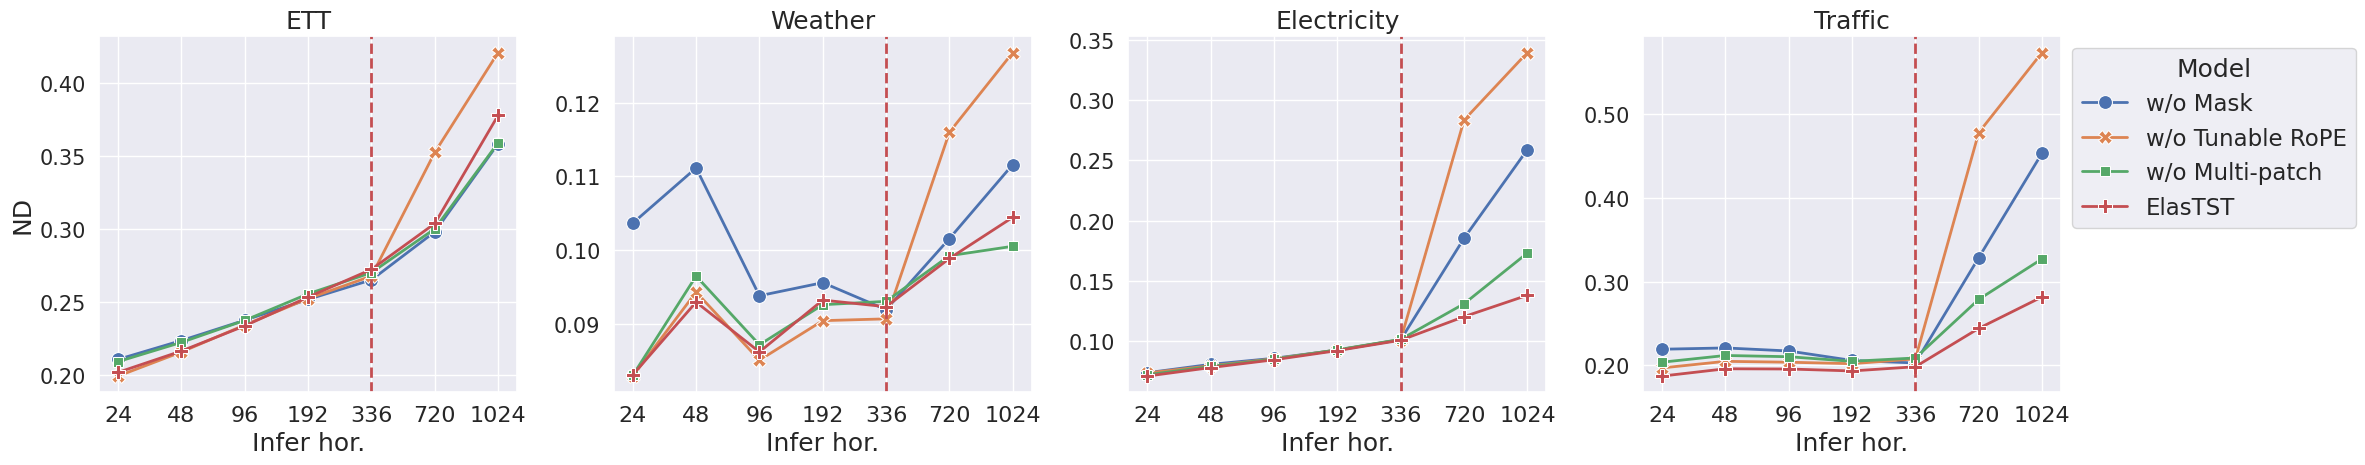

In [15]:
abl_df.rename(columns={"model": 'Model'}, inplace=True)
plot_multi_marked_line(abl_df, x='Infer hor.', y='ND', hue='Model', style='Model', datasets=['ETT','Weather', 'Electricity', 'Traffic'],axvline='336', save_name='key_designs')

### point error

In [35]:
def load_pkl(data_path, anchor=None):
    try:
        with open(data_path, 'rb') as pkl_file:
            data = pickle.load(pkl_file)
            result = np.concatenate(data['720']['MAE'], axis=0)
            result = np.mean(result, axis=(0, 2))
            if anchor is not None:
                result = result / anchor
        return result
    except:
        return None


def cal_rel_point_error():
    datasets = ['ettm1','ettm2','etth1','etth2','exchange_ltsf','weather_ltsf','electricity_ltsf','traffic_ltsf']
    # datasets = ['ettm1','ettm2','etth1','etth2']
    dataset_list = []
    model_list = []
    point_ND = []
    for dataset in datasets:
        data_path = f'/data/Blob_WestJP/v-jiawezhang/log/elastst_inference/elastst/{dataset}_ElasTST_0_CTX_96_PRED_720-1024_VALCTX_96_VALPRED_720-1024/point_nd.pkl'
        anchor_data = load_pkl(data_path)
        
        for model in ['elastst_wo_mask','elastst_wo_patch','elastst_wo_trope']:
            data_path = f'/data/Blob_WestJP/v-jiawezhang/log/elastst_inference/{model}/{dataset}_ElasTST_0_CTX_96_PRED_720-1024_VALCTX_96_VALPRED_720-1024/point_nd.pkl'
            data = load_pkl(data_path, anchor=anchor_data)
            if data is None:
                continue
            
            dataset_list.append(dataset)
            model_list.append(model)
            point_ND.append(data)
            
    res_dict = {"dataset": dataset_list, "model": model_list, "Rel. MAE wrt. ElasTST": point_ND}

    return pd.DataFrame(res_dict)
        

In [36]:
point_error = cal_rel_point_error()

In [37]:
df_exploded = point_error.explode("Rel. MAE wrt. ElasTST").reset_index(drop=True)
df_exploded["Rel. MAE wrt. ElasTST"] = df_exploded["Rel. MAE wrt. ElasTST"].astype(float)
df_exploded['Hor.'] = df_exploded.groupby(['dataset', 'model']).cumcount()
df_exploded = replace_dataset_name(df_exploded)
df_exploded = replace_ABL_name(df_exploded)

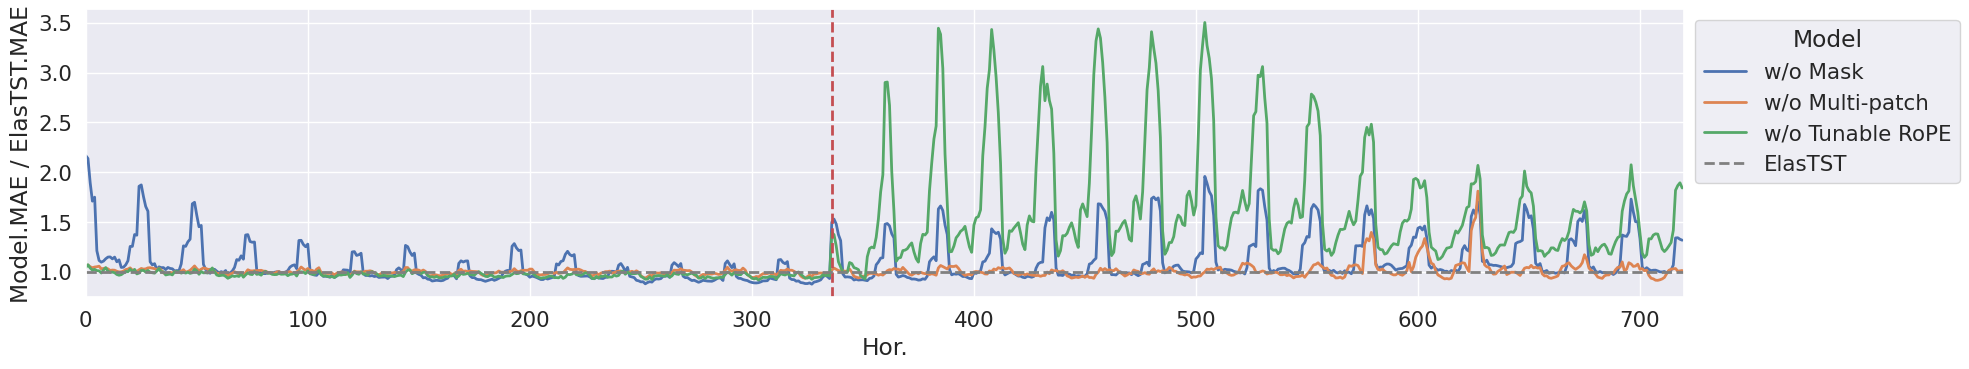

In [41]:
# all_dataset = ['ETTm1','ETTm2','ETTh1','ETTh2','Exchange','Weather', 'Traffic', 'Electricity']
all_dataset = ['ETTm1','ETTm2','ETTh1','ETTh2','Exchange','Weather','Electricity']
df_exploded.rename(columns={"Rel. MAE wrt. ElasTST": 'Model.MAE / ElasTST.MAE','model':'Model'}, inplace=True)
plot_multi_marked_line(df_exploded, x='Hor.', y='Model.MAE / ElasTST.MAE', hue='Model', 
                       datasets=all_dataset,axvline=336,width=20, hight=4, axhline=1,axhline_label='ElasTST',x_min=0, x_max=720, all_in_one=True,save_name='point_performance_gain',font_scale=1.4)

## position Embedding

In [11]:
# model_abl = ['elastst_wo_mask','elastst','elastst_wo_patch','elastst_wo_trope']
model_abl = ['elastst_abs_pe', 'elastst_learnable_pe', 'elastst_wo_pe', 'elastst_wo_trope','elastst']
pred_len_list = ['336']
combined_pos_df = pd.DataFrame()
for model in model_abl:
    elastst_abl = load_result(root_dir = f"/data/Blob_WestJP/v-jiawezhang/log/pos_emb_abl/{model}/", verbose=False, models=['ElasTST'], train_pred_len_list=pred_len_list, is_train=True, dropna=False) 
    elastst_abl['Pos. Emb.'] = model
    combined_pos_df = pd.concat([combined_pos_df, elastst_abl], ignore_index=True)
    

In [12]:
pos_df = replace_dataset_name(combined_pos_df)
pos_df = replace_PE_name(pos_df)
pos_df.loc[:,'Pos. Emb.'] = pos_df['Pos. Emb.'].replace('elastst', 'Tunable RoPE', regex=True)
pos_df['Infer hor.'] = pos_df['Infer hor.'].astype(str)
sort_order_dict = {'Pos. Emb.': ['w/o PE', 'Abs PE', 'Learn PE', 'RoPE', 'Tunable RoPE']}
# sort_order_dict = {'model': ['elastst_wo_pe','elastst_abs_pe', 'elastst_learnable_pe', 'elastst_wo_trope','elastst']}
pos_df = sort_order(pos_df, sort_order_dict=sort_order_dict,inf_sort_order=True)

<Figure size 640x480 with 0 Axes>

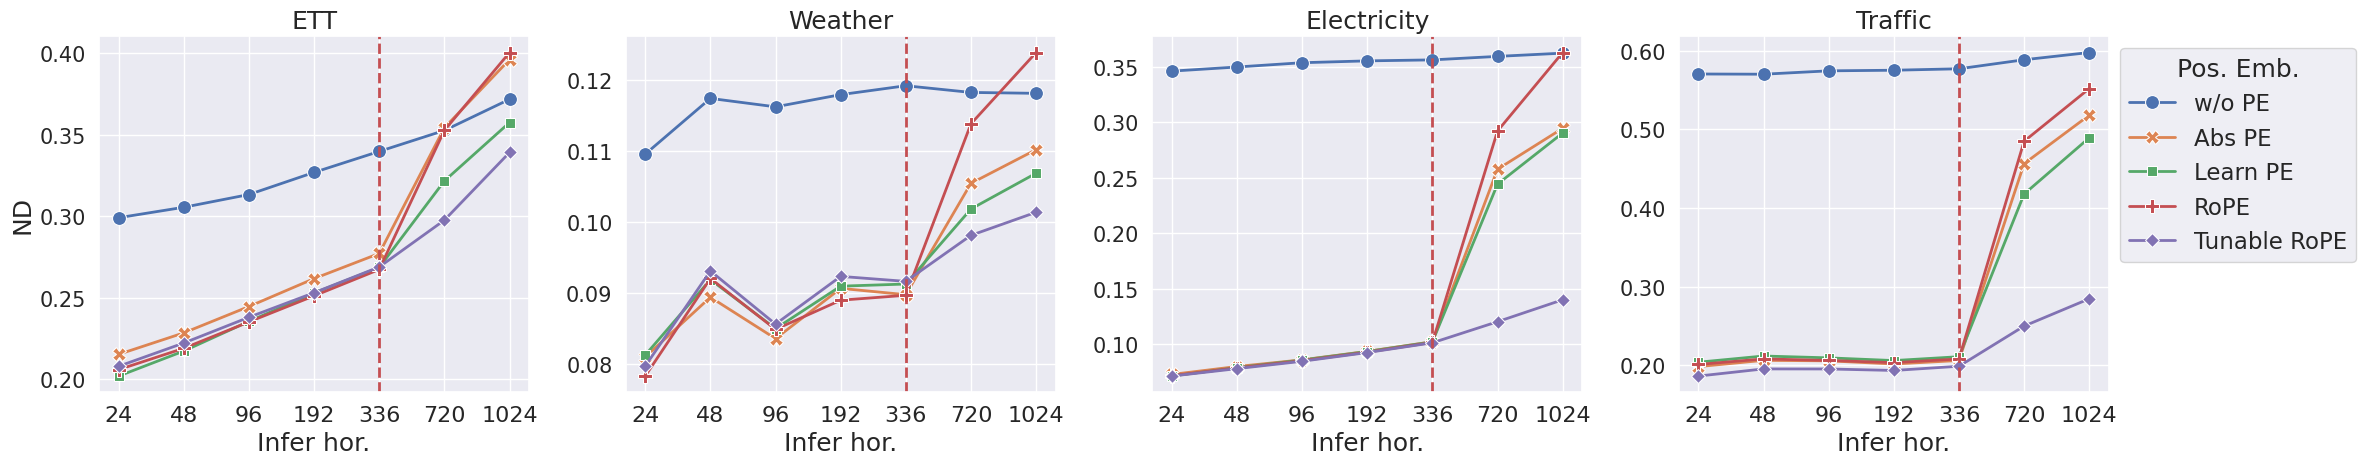

In [13]:
# plot_multi_marked_line(pos_df, x='Infer hor.', y='ND', hue='model', style='model', datasets=['ETTh1','ETTh2','ETTm1','ETTm2'], axvline='336')
plot_multi_marked_line(pos_df, x='Infer hor.', y='ND', hue='Pos. Emb.', style='Pos. Emb.', datasets=['ETT','Weather', 'Electricity','Traffic'], axvline='336',save_name='pos_emb_abl')

## Patch Size

In [14]:
# model_abl = ['elastst_wo_mask','elastst','elastst_wo_patch','elastst_wo_trope']
model_abl = ['1', '8', '16', '32','1_8', '1_8_16', '1_8_16_32','8_16', '8_16_32']
pred_len_list = ['336']
combined_patch_df = pd.DataFrame()
for model in model_abl:
    elastst_abl = load_result(root_dir = f"/data/Blob_WestJP/v-jiawezhang/log/elastst/patch_abl/{model}/", verbose=False, models=['ElasTST'], train_pred_len_list=pred_len_list, is_train=True, dropna=False) 
    elastst_abl['model'] = model
    combined_patch_df = pd.concat([combined_patch_df, elastst_abl], ignore_index=True)



In [15]:
patch_df = replace_dataset_name(combined_patch_df)
patch_df['Infer hor.'] = patch_df['Infer hor.'].astype(str)
# sort_order_dict = {'model': ['1', '8', '16', '32','1_8', '1_8_16', '1_8_16_32','8_16', '8_16_32']}
sort_order_dict = {'model': ['1', '8', '16', '32','1_8_16_32','8_16_32'],'Infer hor.': ['96', '192', '336', '720', '1024']}
patch_df = sort_order(patch_df, sort_order_dict=sort_order_dict,inf_sort_order=False)

In [16]:
def plot_bar(res_pd, y_min=None, save_name=None, ):
    sns.set(font_scale=1.5)

    plt.figure(figsize=(15,3) ) #,dpi=300)
    # res_pd = get_difference(res_pd)
    # hue_order = ['8', '16', '32', '64', '8_16', '8_16_32','8_16_32_64']
    hue_order = ['1', '8', '16', '32','1_8_16_32','8_16_32']
    sns.barplot(
        data=res_pd, errorbar=None,
        x='Infer hor.', y="ND", hue='model', hue_order=hue_order)
    if y_min is not None:
        plt.ylim(y_min, None)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Patch')  
    plt.xlabel('Forecasting Horizons')  
    plt.ylabel('NMAE')  
    plt.tight_layout() 
    # plt.show()
    if save_name is not None:
        plt.savefig(f'fig/{save_name}.svg', format='svg') 

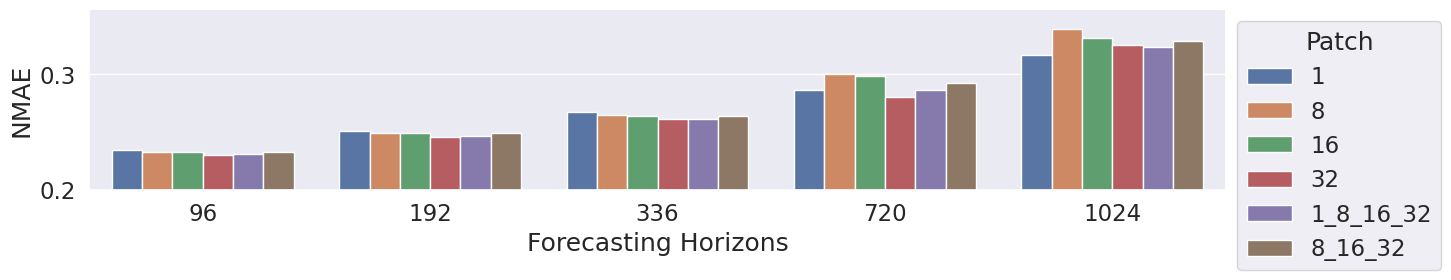

In [17]:
fileds_dict = {'dataset': ['ETTh1','ETTm1','ETTh2','ETTm2']}
filt_patch_df = filed_filter(patch_df, fileds_dict, eq=True)
plot_bar(filt_patch_df, y_min=0.2, save_name='ett_multi_patch')

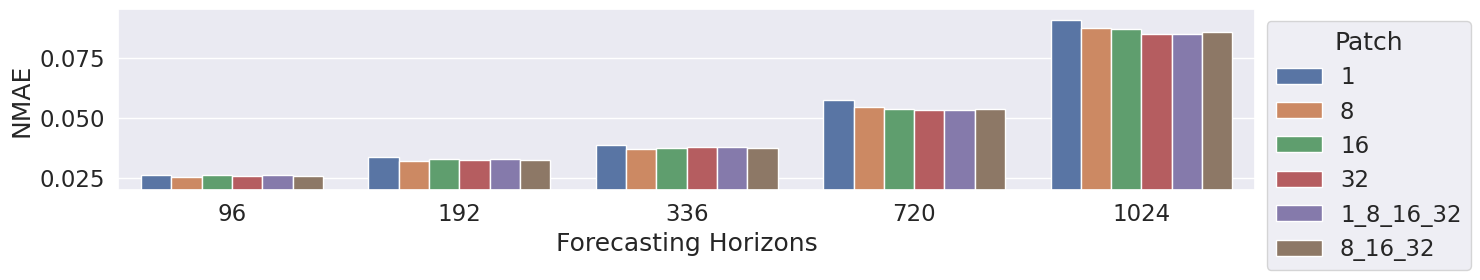

In [18]:
fileds_dict = {'dataset': ['Exchange']}
filt_patch_df = filed_filter(patch_df, fileds_dict, eq=True)
plot_bar(filt_patch_df, y_min=0.02, save_name='exchange_multi_patch')

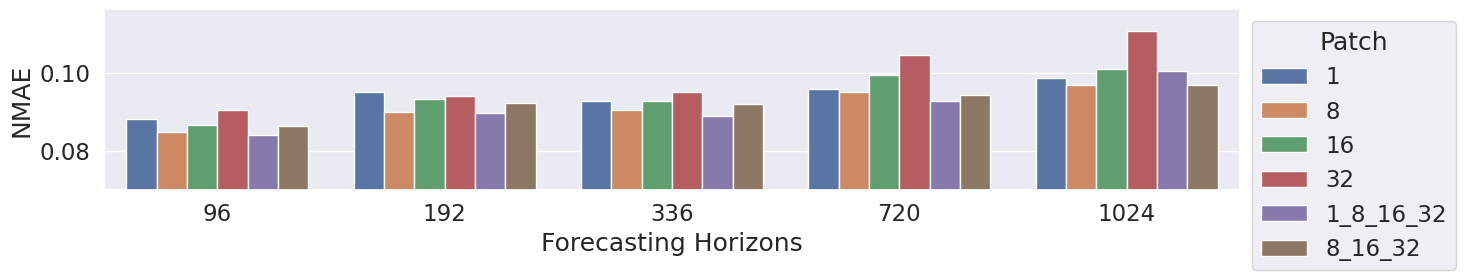

In [19]:
fileds_dict = {'dataset': ['Weather']}
filt_patch_df = filed_filter(patch_df, fileds_dict, eq=True)
plot_bar(filt_patch_df, y_min=0.07, save_name='weather_multi_patch')

# Computation Cost

In [15]:
def load_summary(root_dir, verbose=True, models=['ElasTST'], train_pred_len_list=['96-192-336-720'], datasets=None):
    dataset_list = []
    param_list = []
    mem_list = []

    if datasets is None:
        datasets = ['ettm1','ettm2','etth1','etth2','exchange_ltsf','weather_ltsf','electricity_ltsf','traffic_ltsf']

    seed=0
    train_context = 96
    val_context = 96
    for dataset in datasets:
        for model in models:
            for train_pred_len in train_pred_len_list:
                for cont_sample in ['true', 'false']:
                    for val_len in [train_pred_len]:
                        if cont_sample == 'true':
                            cont = '_cont_sample'
                        else:
                            cont = ''
                    
                        json_file = root_dir + f"{dataset}_{model}_{seed}_CTX_{train_context}_PRED_{train_pred_len}_VALCTX_{val_context}_VALPRED_{val_len}{cont}/summary.json"
                
                        try:
                            with open(json_file, 'r') as file:
                                data = json.load(file)
                        except:
                            if verbose:
                                print("cannot find ", json_file) 
                            continue
                        
                        trainable_parameters = data['trainable_parameters']
                        trainable_parameters_in_mb = trainable_parameters * 4 / (1024 ** 2)
                        train_mem_peak = data['memory_summary']['train']['mem_peak']
                        
                        dataset_list.append(dataset)
                        param_list.append(trainable_parameters_in_mb)
                        mem_list.append(train_mem_peak)



    res_dict = {"dataset": dataset_list, 'NPARAMS (MB)': param_list, 'Max GPU Mem. (GB)': mem_list}

    return pd.DataFrame(res_dict)

def gpu_dataframe_to_markdown(df, filed='Max GPU Mem. (GB)'):
    # df.loc[:,'model'] = df['model'].replace('TransformerForecaster', 'Transformer', regex=True) 
    df.loc[:, filed] = df[filed].round(4)
    # df = df.pivot_table(index=['dataset'], columns='model', values=filed).reset_index()
    df = df.pivot_table(index=['dataset'], columns='model', values=filed, observed=False).reset_index()
    return df.to_markdown(index=False)

In [23]:
# model_abl = ['elastst', 'nhits','patchtst','transformer_enc','autoformer','tsmixer']
model_abl = ['elastst', 'patchtst','transformer_enc','autoformer']
pred_len_list = ['1024']
datasets = ['ettm1','weather_ltsf']
combined_gpu_df = pd.DataFrame()
for model in model_abl:
    root_dir = f"/data/Blob_WestJP/v-jiawezhang/log/mem_compare2/{model}/"
    elastst_abl = load_summary(root_dir, verbose=False, models=['PatchTST','ElasTST','NHiTS','TransformerEnc', 'Autoformer','TSMixer'], train_pred_len_list=pred_len_list, datasets=datasets)
    elastst_abl['model'] = model
    combined_gpu_df = pd.concat([combined_gpu_df, elastst_abl], ignore_index=True)

In [24]:
gpu_df = replace_dataset_name(combined_gpu_df)
gpu_markdown = gpu_dataframe_to_markdown(gpu_df, filed='Max GPU Mem. (GB)')

In [26]:
print(gpu_markdown)

| dataset   |   autoformer |   elastst |   patchtst |   transformer_enc |
|:----------|-------------:|----------:|-----------:|------------------:|
| ETTm1     |       0.1678 |    0.0539 |     0.0389 |            0.1516 |
| Weather   |       0.1687 |    0.0991 |     0.04   |            0.1519 |


## RoPE

In [72]:
model_abl = ['elastst_abs_pe', 'elastst_wo_pe', 'elastst_wo_trope','elastst_trope'] # 'elastst_learnable_pe', 
pred_len_list = ['1024']
combined_gpu_df = pd.DataFrame()
for model in model_abl:
    # root_dir = f"/data/Blob_WestJP/v-jiawezhang/log/pos_emb_abl/{model}/"
    root_dir = f"/data/Blob_WestJP/v-jiawezhang/log/mem_compare2/{model}/"
    elastst_abl = load_summary(root_dir, verbose=False, models=['ElasTST'], train_pred_len_list=pred_len_list, datasets=None)
    elastst_abl['model'] = model
    combined_gpu_df = pd.concat([combined_gpu_df, elastst_abl], ignore_index=True)

In [73]:
gpu_df = replace_dataset_name(combined_gpu_df)
# gpu_df = replace_PE_name(gpu_df)
# sort_order_dict = {'model': ['w/ Abs PE', 'w/ RoPE', 'ElasTST']}
# gpu_df = sort_order(gpu_df, sort_order_dict=sort_order_dict,inf_sort_order=False)
# fileds_dict = {'dataset': ['Traffic', 'Electricity']}
# gpu_df = filed_filter(gpu_df, fileds_dict, eq=False)

In [74]:
gpu_markdown = gpu_dataframe_to_markdown(gpu_df, filed='Max GPU Mem. (GB)')
# gpu_markdown = gpu_dataframe_to_markdown(gpu_df, filed='NPARAMS (MB)')
print(gpu_markdown)

| dataset     |   elastst_abs_pe |   elastst_trope |   elastst_wo_pe |   elastst_wo_trope |
|:------------|-----------------:|----------------:|----------------:|-------------------:|
| ETTm1       |           0.048  |          0.0539 |          0.048  |             0.0539 |
| Electricity |           0.8109 |          1.0685 |          0.8109 |             1.0685 |
| Weather     |           0.0823 |          0.0991 |          0.0823 |             0.0995 |


## patch size

In [8]:
# model_abl = ['1', '8', '16', '32','1_8', '1_8_16', '1_8_16_32','8_16', '8_16_32']
model_abl = ['1', '8', '16', '32','1_8_16_32','8_16_32']
pred_len_list = ['1024']
combined_gpu_df = pd.DataFrame()
for model in model_abl:
    # root_dir = f"/data/Blob_WestJP/v-jiawezhang/log/elastst/patch_abl/{model}/"
    root_dir = f"/data/Blob_WestJP/v-jiawezhang/log/mem_compare2/{model}/"
    elastst_abl = load_summary(root_dir, verbose=False, models=['ElasTST'], train_pred_len_list=pred_len_list, datasets=None)
    elastst_abl['model'] = model
    combined_gpu_df = pd.concat([combined_gpu_df, elastst_abl], ignore_index=True)

In [12]:
gpu_df = replace_dataset_name(combined_gpu_df)

# sort_order_dict = {'model': ['1', '8', '16', '32','1_8', '1_8_16', '1_8_16_32','8_16', '8_16_32']}
sort_order_dict = {'model': ['1', '8', '16', '32','1_8_16_32','8_16_32']}
gpu_df = sort_order(gpu_df, sort_order_dict=sort_order_dict,inf_sort_order=False)

# fileds_dict = {'dataset': ['Traffic', 'Electricity']}
# gpu_df = filed_filter(gpu_df, fileds_dict, eq=False)

In [13]:
gpu_markdown = gpu_dataframe_to_markdown(gpu_df, filed='Max GPU Mem. (GB)')
# gpu_markdown = gpu_dataframe_to_markdown(gpu_df, filed='NPARAMS (MB)')

In [14]:
print(gpu_markdown)

| dataset     |        1 |      8 |     16 |     32 |   1_8_16_32 |   8_16_32 |
|:------------|---------:|-------:|-------:|-------:|------------:|----------:|
| ETTm1       |   0.6747 | 0.0536 | 0.0415 | 0.036  |      0.6751 |    0.0539 |
| Electricity | nan      | 1.0682 | 0.5001 | 0.2691 |    nan      |    1.0685 |
| Weather     |   1.9641 | 0.0993 | 0.0616 | 0.0471 |      1.9632 |    0.0991 |


# Transferability of TRoPE

In [91]:
model_abl = ['vanilla', 'rope','trope']
pred_len_list = ['96', '192', '336', '720']
combined_patchtst_df = pd.DataFrame()
for model in model_abl:
    root_dir = f"/data/Blob_WestJP/v-jiawezhang/log/patchtst_trope/{model}/"
    elastst_abl = load_result(root_dir, verbose=False, models=['PatchTST'], train_pred_len_list=pred_len_list, datasets=None, is_train=True, dropna=False)
    elastst_abl['model'] = model
    combined_patchtst_df = pd.concat([combined_patchtst_df, elastst_abl], ignore_index=True)

In [92]:
patchtst_df = replace_dataset_name(combined_patchtst_df)

In [90]:
patchtst_df

,dataset,NPARAMS (MB),Max GPU Mem. (GB),model
0,ETTm1,5.141750,0.047618,vanilla
1,ETTm1,8.753689,0.061347,vanilla
2,ETTm1,14.171597,0.076281,vanilla
3,ETTm1,28.619350,0.122224,vanilla
4,ETTm2,5.141750,0.047618,vanilla
...,...,...,...,...
73,Weather,2.561893,0.082168,trope
74,Weather,3.335880,0.087140,trope
75,Weather,5.399845,0.094867,trope
76,Traffic,446.317543,1.917718,trope


<Figure size 640x480 with 0 Axes>

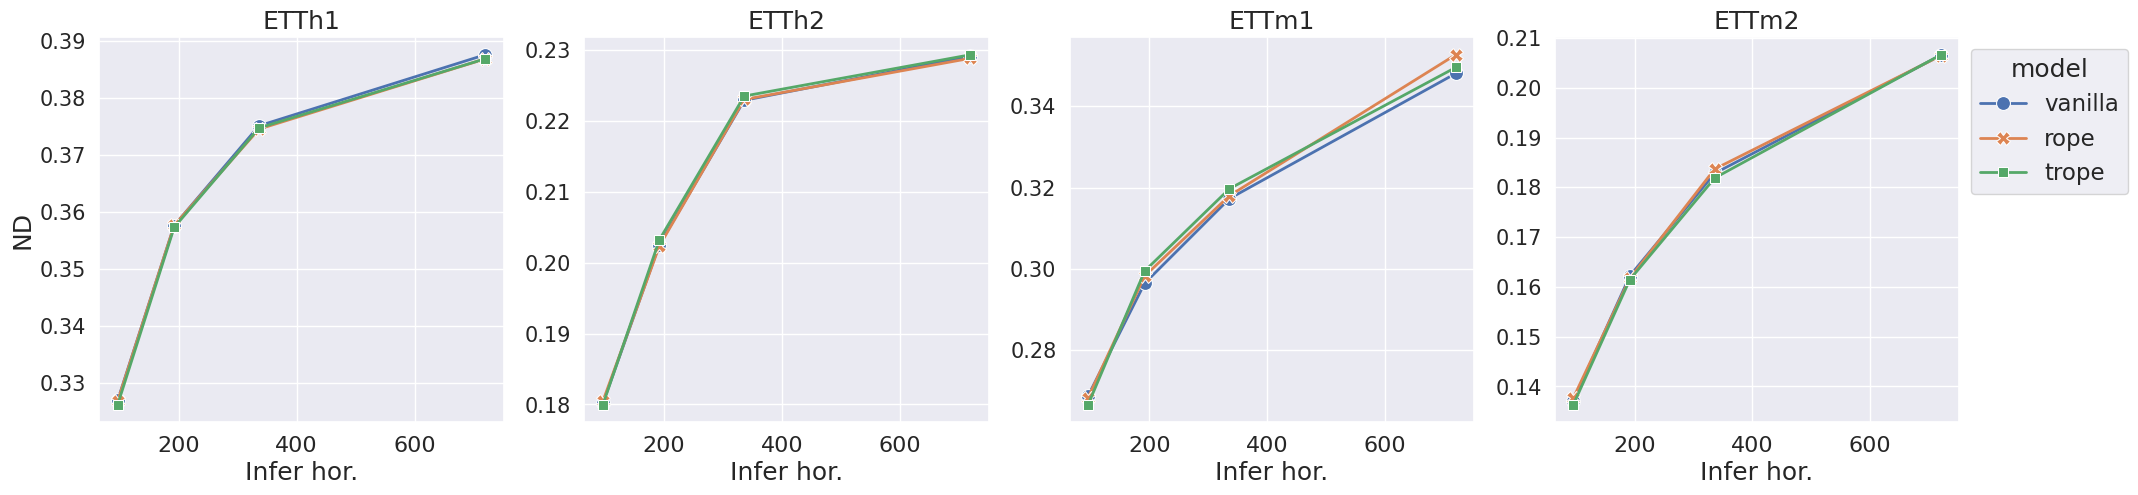

<Figure size 640x480 with 0 Axes>

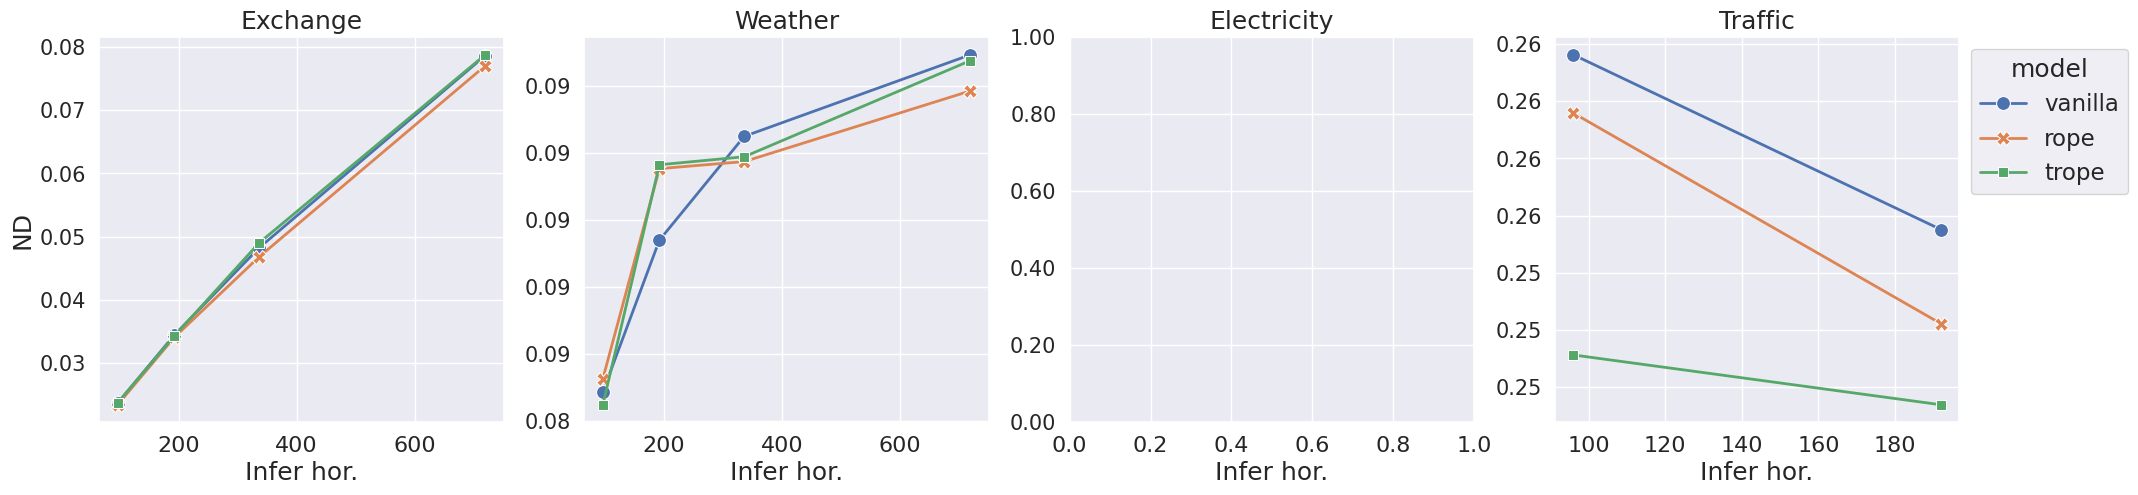

In [93]:
plot_multi_marked_line(patchtst_df, x='Infer hor.', y='ND', hue='model', style='model', datasets=['ETTh1','ETTh2','ETTm1','ETTm2'])
plot_multi_marked_line(patchtst_df, x='Infer hor.', y='ND', hue='model', style='model', datasets=['Exchange','Weather', 'Electricity','Traffic'])